## 🧩 Classification Task — K-Nearest Neighbors (KNN)

In this section, we apply the **K-Nearest Neighbors (KNN)** algorithm to the **MAGIC Gamma Telescope** dataset.

The objective is to classify events as either **Gamma (signal)** or **Hadron (background)** based on the provided features.

We will perform two implementations:

1. **Manual KNN Implementation**  
   - Compute Euclidean distances manually.  
   - Identify the *k* nearest neighbors.  
   - Predict based on majority voting.  
   - Experiment with different values of *k* to study underfitting and overfitting trends.

2. **Scikit-Learn KNN Implementation**  
   - Use `sklearn.neighbors.KNeighborsClassifier`.  
   - Compare its performance with the manual approach.  

We will evaluate and compare both models using:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-Score**
- **Confusion Matrix**

Finally, we will plot **Validation Accuracy vs. K values** for both models and discuss the optimal *k* value.


### Importing necessary libs

In [7]:
import os
import sys
import numpy as np
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.append(project_root)
import importlib
import src.plots
importlib.reload(src.plots)


from src.utils import load_dataset,split_data,classification_metrics,regression_metrics
from src.plots import  plot_validation_curve ,plot_single_cat, show_heatmap

### Performing some EDA

In [8]:
df = load_dataset("../data/telescope_data/telescope_data.csv")
df.info()
df.describe(include='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  19020 non-null  int64  
 1   fLength     19020 non-null  float64
 2   fWidth      19020 non-null  float64
 3   fSize       19020 non-null  float64
 4   fConc       19020 non-null  float64
 5   fConc1      19020 non-null  float64
 6   fAsym       19020 non-null  float64
 7   fM3Long     19020 non-null  float64
 8   fM3Trans    19020 non-null  float64
 9   fAlpha      19020 non-null  float64
 10  fDist       19020 non-null  float64
 11  class       19020 non-null  object 
dtypes: float64(10), int64(1), object(1)
memory usage: 1.7+ MB


,class
count,19020
unique,2
top,g
freq,12332


In [9]:
df.head(10)

,Unnamed: 0,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
5,5,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.0980,g
6,6,48.2468,17.3565,3.0332,0.2529,0.1515,8.5730,38.0957,10.5868,4.7920,219.0870,g
7,7,26.7897,13.7595,2.5521,0.4236,0.2174,29.6339,20.4560,-2.9292,0.8120,237.1340,g
8,8,96.2327,46.5165,4.1540,0.0779,0.0390,110.3550,85.0486,43.1844,4.8540,248.2260,g
9,9,46.7619,15.1993,2.5786,0.3377,0.1913,24.7548,43.8771,-6.6812,7.8750,102.2510,g


#### we may notice imbalance between the two target categories

* let's do some visualization

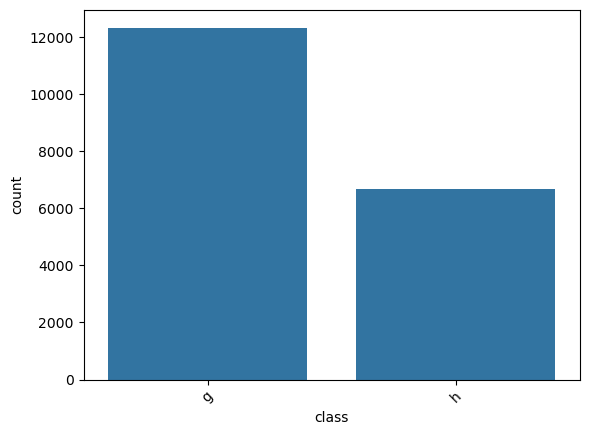

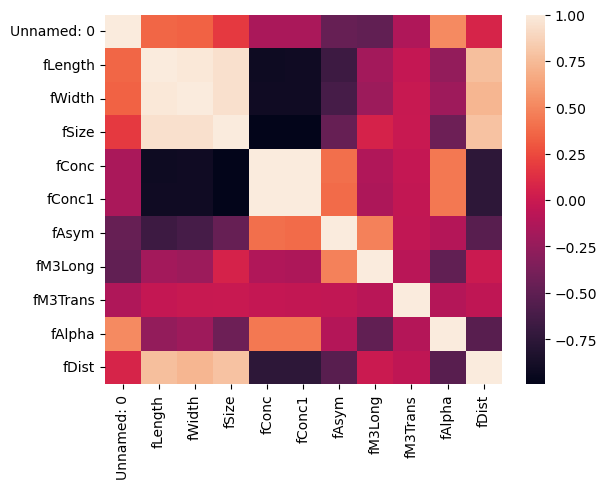

In [10]:
plot_single_cat("class", df)
numeric_df = df.select_dtypes(include=['number'])
show_heatmap(numeric_df.corr())


we may notice some feature are highly correlated

let's drop them out


In [11]:
corr_matrix = df.drop(columns=['class']).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_reduced = df.drop(columns=to_drop)
df_reduced['class'] = df_reduced['class'].map({'g': 0, 'h': 1})
df_reduced =df_reduced.drop(columns=['Unnamed: 0'])

df_reduced.head(10)


,fLength,fWidth,fSize,fConc,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,27.7004,22.0110,-8.2027,40.0920,81.8828,0
1,31.6036,11.7235,2.5185,0.5303,26.2722,23.8238,-9.9574,6.3609,205.2610,0
2,162.0520,136.0310,4.0612,0.0374,116.7410,-64.8580,-45.2160,76.9600,256.7880,0
3,23.8172,9.5728,2.3385,0.6147,27.2107,-6.4633,-7.1513,10.4490,116.7370,0
4,75.1362,30.9205,3.1611,0.3168,-5.5277,28.5525,21.8393,4.6480,356.4620,0
5,51.6240,21.1502,2.9085,0.2420,50.8761,43.1887,9.8145,3.6130,238.0980,0
6,48.2468,17.3565,3.0332,0.2529,8.5730,38.0957,10.5868,4.7920,219.0870,0
7,26.7897,13.7595,2.5521,0.4236,29.6339,20.4560,-2.9292,0.8120,237.1340,0
8,96.2327,46.5165,4.1540,0.0779,110.3550,85.0486,43.1844,4.8540,248.2260,0
9,46.7619,15.1993,2.5786,0.3377,24.7548,43.8771,-6.6812,7.8750,102.2510,0


### Balancing Data and Splitting

In [12]:
features = df_reduced.drop('class', axis = 1)
y = df_reduced["class"]

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

X_train, X_val, X_test, y_train, y_val, y_test = split_data(features, y)

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
y_train = y_train.reset_index(drop=True)
print(y.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)



class
0    0.64837
1    0.35163
Name: proportion, dtype: float64
class
0    0.5
1    0.5
Name: proportion, dtype: float64


### now it's time to predict

In [13]:
# Reload both files
importlib.reload(src.knn_manual)
importlib.reload(src.utils)


<module 'src.utils' from '/Users/mac/Studying/Machine learning/KNN_Linear_regression_manual_built-in/assignment_1/src/utils.py'>

In [14]:

# Re-import after reload
from src.utils import evaluate_knn_for_ks
from src.knn_manual import KNN_predict



ks = [1,3,5,7,9]
results = evaluate_knn_for_ks(X_train,y_train,X_val,y_val,ks)
import pandas as pd

df_results = pd.DataFrame(results)
print(df_results)


meow
Type of y_train: <class 'pandas.core.series.Series'>
First few indices of y_train (if Series): RangeIndex(start=0, stop=10, step=1)
First few values of y_train: [0 0 0 0 0 0 0 0 0 0]
meow
Type of y_train: <class 'pandas.core.series.Series'>
First few indices of y_train (if Series): RangeIndex(start=0, stop=10, step=1)
First few values of y_train: [0 0 0 0 0 0 0 0 0 0]
meow
Type of y_train: <class 'pandas.core.series.Series'>
First few indices of y_train (if Series): RangeIndex(start=0, stop=10, step=1)
First few values of y_train: [0 0 0 0 0 0 0 0 0 0]
meow
Type of y_train: <class 'pandas.core.series.Series'>
First few indices of y_train (if Series): RangeIndex(start=0, stop=10, step=1)
First few values of y_train: [0 0 0 0 0 0 0 0 0 0]
meow
Type of y_train: <class 'pandas.core.series.Series'>
First few indices of y_train (if Series): RangeIndex(start=0, stop=10, step=1)
First few values of y_train: [0 0 0 0 0 0 0 0 0 0]
   accuracy  precision    recall  f1_score           confusi

let's visualize our results

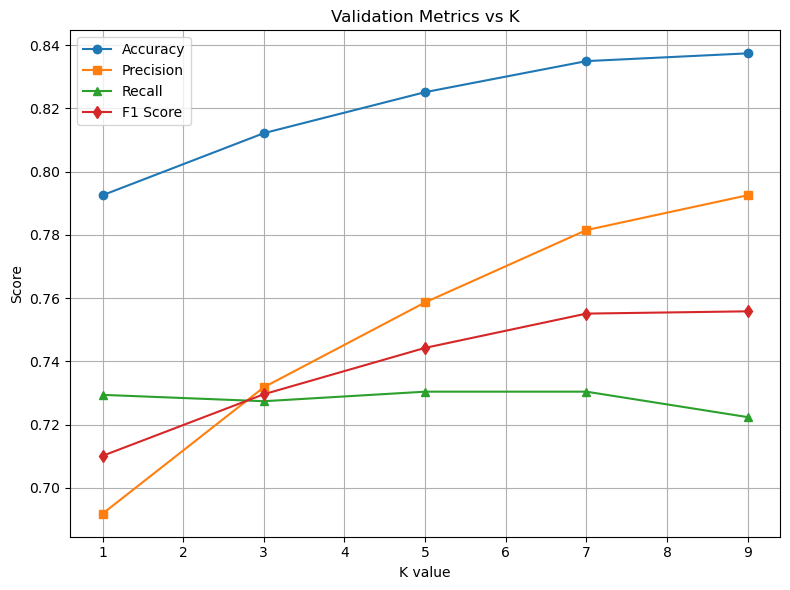

In [15]:
importlib.reload(src.plots)
from src.plots import plot_validation_curve
plot_validation_curve(df_results)

## now we concluded that the best K from manual KNN is 9 since data is balanced so we mostly care about accuracy

### now let's try sklearn version

   accuracy  precision    recall  f1_score           confusion_matrix  k
0  0.792499   0.691794  0.729376  0.710088  [[1536, 323], [269, 725]]  1
1  0.812128   0.731781  0.727364  0.729566  [[1594, 265], [271, 723]]  3
2  0.825096   0.758621  0.730382  0.744234  [[1628, 231], [268, 726]]  5
3  0.834911   0.781485  0.730382  0.755070  [[1656, 203], [268, 726]]  7
4  0.837364   0.792494  0.722334  0.755789  [[1671, 188], [276, 718]]  9


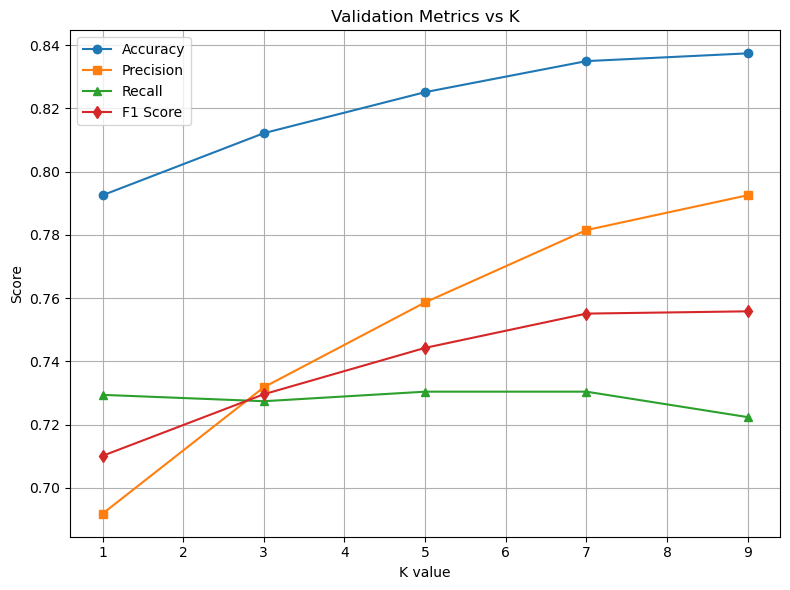

In [16]:
from sklearn.neighbors import KNeighborsClassifier

accuracies = []
ks = [1, 3, 5, 7, 9]

for k in ks:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    metrics = classification_metrics(y_val, y_pred)
    metrics["k"] = k               
    accuracies.append(metrics)

df_results = pd.DataFrame(accuracies)
print(df_results)

plot_validation_curve(df_results)


## same behavior 

### now we test the k = 9 

In [17]:
importlib.reload(src.knn_manual)
from src.knn_manual import KNN_predict
y_manual_pred = KNN_predict(X_train,y_train,X_test,k=9)
y_builtin_pred = model.predict(X_test)


meow
Type of y_train: <class 'pandas.core.series.Series'>
First few indices of y_train (if Series): RangeIndex(start=0, stop=10, step=1)
First few values of y_train: [0 0 0 0 0 0 0 0 0 0]


   accuracy  precision    recall  f1_score           confusion_matrix  k
0  0.835612   0.784958  0.735849   0.75961  [[1643, 203], [266, 741]]  9
   accuracy  precision    recall  f1_score           confusion_matrix  k
0  0.835612   0.784958  0.735849   0.75961  [[1643, 203], [266, 741]]  9


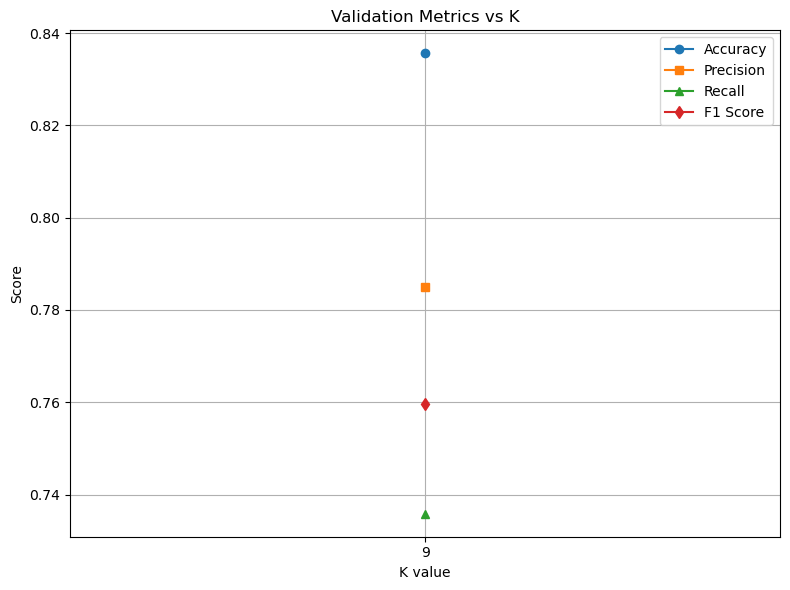

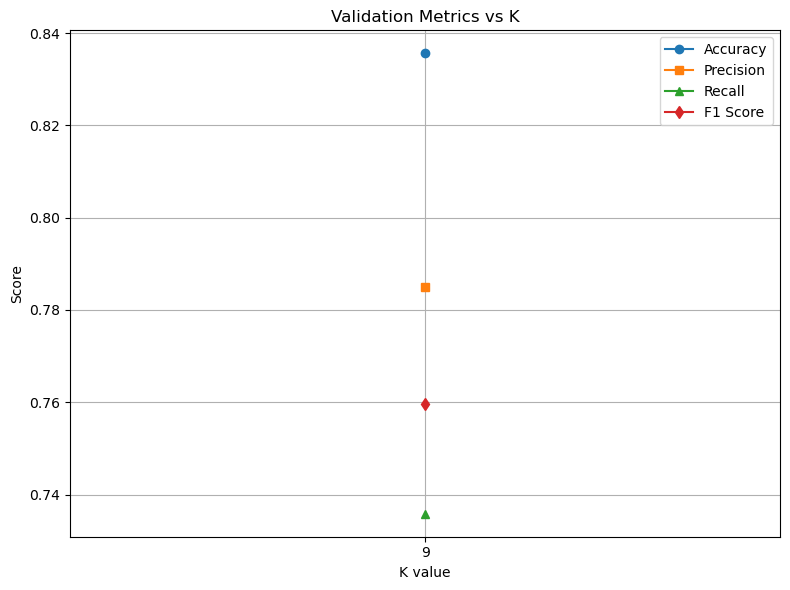

In [21]:

metrics_manual = classification_metrics(y_test,y_manual_pred)
metrics_manual['k'] = '9'

metrics_builtin = classification_metrics(y_test,y_builtin_pred)
metrics_builtin['k'] = '9'
df_manual_results = pd.DataFrame([metrics_manual])
print(df_manual_results)
df_builtin_results = pd.DataFrame([metrics_builtin])
print(df_builtin_results)

plot_validation_curve(df_manual_results)
plot_validation_curve(df_builtin_results)


### let's try and compare both models

In [22]:
comparison = df_manual_results.merge(df_builtin_results, on='k', suffixes=('_manual', '_builtin'))
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
    comparison[f'{metric}_diff'] = abs(comparison[f'{metric}_manual'] - comparison[f'{metric}_builtin'])

print(comparison)

   accuracy_manual  precision_manual  recall_manual  f1_score_manual  \
0         0.835612          0.784958       0.735849          0.75961   

     confusion_matrix_manual  k  accuracy_builtin  precision_builtin  \
0  [[1643, 203], [266, 741]]  9          0.835612           0.784958   

   recall_builtin  f1_score_builtin   confusion_matrix_builtin  accuracy_diff  \
0        0.735849           0.75961  [[1643, 203], [266, 741]]            0.0   

   precision_diff  recall_diff  f1_score_diff  
0             0.0          0.0            0.0  
